# 畳み込みニューラルネットワーク

今回は畳み込みニューラルネットワーク（CNN）を扱っていく。
CNNは、画像認識や音声認識など、いたるところで使われている。また、画像認識においてはディープラーニングによる手法のほとんどがCNNをベースとして作られている。

# CNNの基本的な形

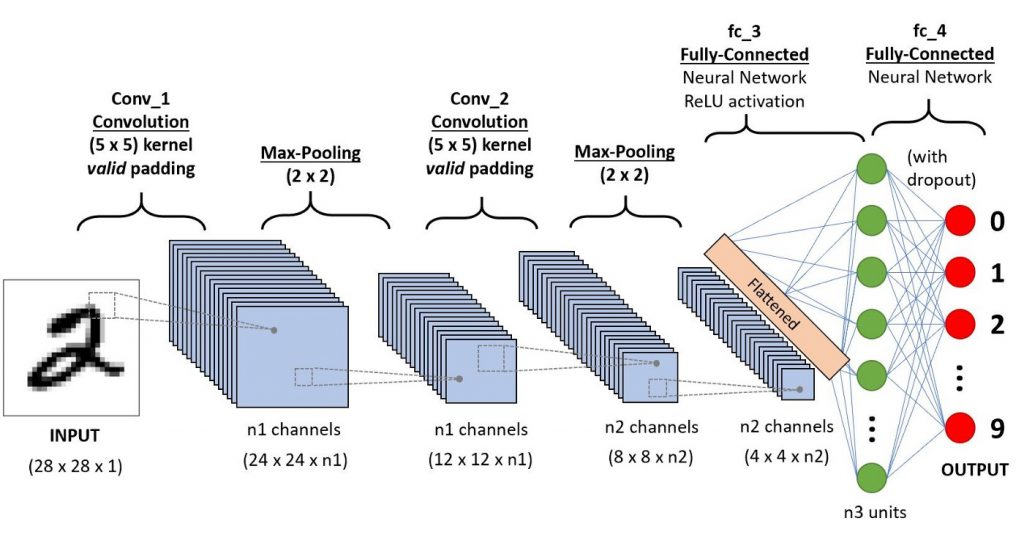CNNでは新しく「Convolutionレイヤ」と「Poolingレイヤ」が加わります。

出力に近い層では、これまでのAffine-ReLUという組み合わせが用いられ、最後の出力層においてはAffine-Softmaxの組み合わせが用いられるのは、一般的なCNNでよく見られる構成です。

# 畳み込み層

畳み込み層（Convolutionレイヤ）では、形状を維持することが特徴です。画像の場合、入力データを三次元データとして受け取り、同じく三次元のデータとして次の層にデータを出力します。

畳み込み層で行う処理は、畳み込み演算です。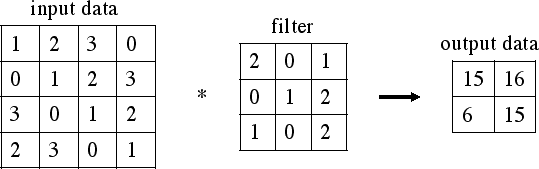

畳み込み演算は、入力データに対してフィルターのウィンドウを一定の間隔でスライドさせながら適用していく。ここでいうウィンドウとは、図における3*3の部分を示す。それぞれの場所でフィルター要素と入力の対応する要素を乗算し、その和を求めます。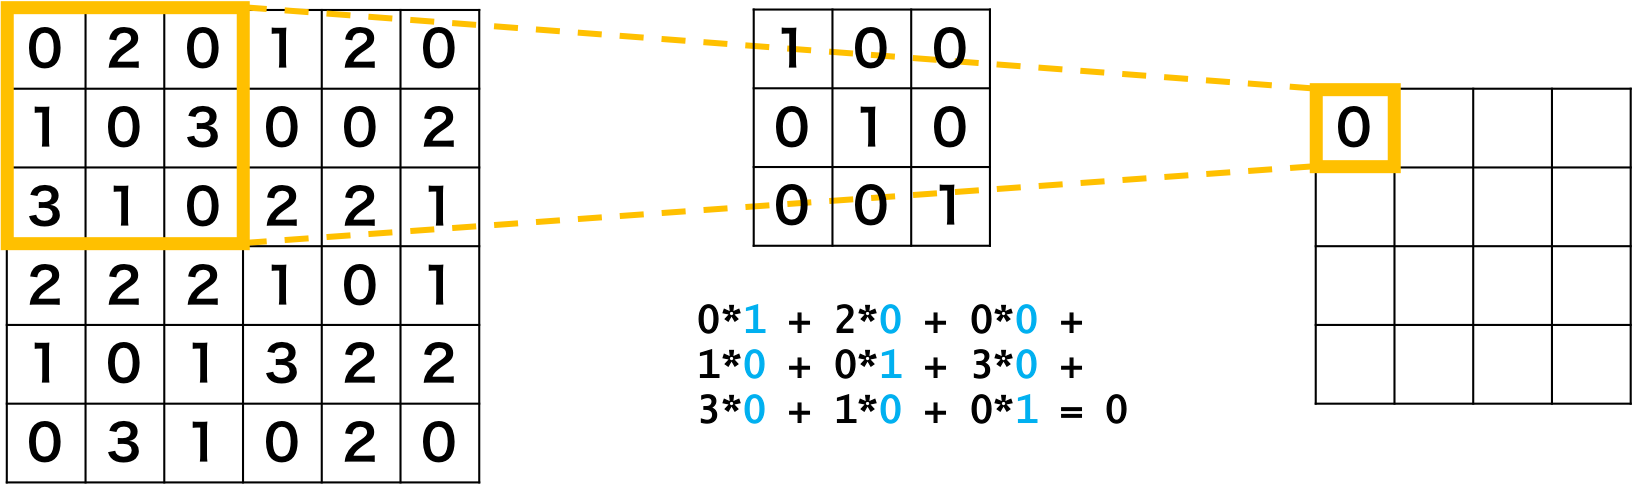

# プーリング層

プーリングは、縦横方向の空間を小さくする演算。学習するパラメータがない＝最大領域から最大値もしくは平均を取るだけの処理であるため、学習すべきパラメータが存在しないこと。プーリングの演算によって入力データと出力データのチャンネル数に変化はない。チャンネルごとによって独立して計算が行われる。入力データの小さなズレに対して頑健という特徴がある。

# Convolution,Poolingレイヤの実装

# im2colによる展開　　　

CNNの四次元配列のデータを効率よく処理するために、二次元配列に展開をする。行列計算に変換することでこれまでと同じように計算することができる。

In [1]:
import cupy as cp

ModuleNotFoundError: No module named 'cupy'

In [15]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    
    # 入力データのサイズを取得
    N, C, H, W = input_data.shape
    
    # 出力データのサイズを計算
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    
    # パディング
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    
    # 出力データの受け皿を初期化
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    # 行方向のインデックス
    for y in range(filter_h):
        # 行方向の最大値を計算
        y_max = y + stride * out_h
        
        # 列方向のインデックス
        for x in range(filter_w):
            # 列方向の最大値を計算
            x_max = x + stride * out_w
            
            # フィルターのy,x要素に対応する入力データの要素を抽出
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # 出力サイズに整形
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

In [16]:
# 入力データ数を指定
input_num = 10

# 入力データのチャンネルを指定
C = 3

# 入力データの高さを指定
input_h = 7

# 入力データの横幅を指定
input_w = 7

# フィルター数を指定
filter_num = 3

# フィルターの高さを指定
filter_h = 5

# フィルターの横幅を指定
filter_w = 5

In [17]:
# 入力データをランダムに生成
input_data = np.random.rand(input_num, C, input_h, input_w)
print(input_data.shape)

# 2次元配列に変換
input_data_col = im2col(input_data, filter_h, filter_w, stride=1, pad=0)
print(input_data_col.shape)

(10, 3, 7, 7)
(90, 75)


In [18]:
# フィルターの重みをランダムに生成
W = np.random.rand(filter_num, C, filter_h, filter_w)
print(W.shape)

# 2次元配列に変換
W_col = W.reshape(filter_num, -1).T
print(W_col.shape)

(3, 3, 5, 5)
(75, 3)


In [19]:
# 行列の積を計算
output_data_col = np.dot(input_data_col, W_col)
print(output_data_col.shape)

# 4次元配列に再変換
output_data = output_data_col.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
print(output_data.shape)

(90, 3)
(2, 15, 3, 3)


In [20]:
# マスターデータの読み込み用の設定
import sys
sys.path.append('C:\\Users\\「ユーザー名」\\Documents\\・・・\\deep-learning-from-scratch-master')

# MNISTデータセット読み込み関数
from dataset.mnist import load_mnist

# これまで実装してきたクラス(classの定義を実行済みなら不要)
from common.layers import *
from common.optimizer import *

# 順番付きディクショナリ
from collections import OrderedDict

# 画像の保存
import pickle

# NumPy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

In [21]:
# 4次元配列対応版Affineレイヤの実装
class Affine:
    
    # インスタンス変数の定義
    def __init__(self, W, b):
        self.W = W # 重み
        self.b = b # バイアス
        self.x = None # 入力データ
        self.original_x_shape = None # 入力データのサイズ
        self.dW = None # 重みに関する勾配
        self.db = None # バイアスに関する勾配
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 入力データのサイズを保存
        self.original_x_shape = x.shape
        
        # バッチサイズ行の2次元配列に変形
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        # 重み付きバイアスの和の計算
        out = np.dot(self.x, self.W) + self.b

        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        # 勾配を計算
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        # 入力データのサイズに変形
        dx = dx.reshape(*self.original_x_shape)
        return dx

# Convolutionレイヤの実装

In [32]:
# Convolutionレイヤの実装
class Convolution:
    
    # インスタンス変数の定義
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W # フィルター(重み)
        self.b = b # バイアス
        self.stride = stride # ストライド
        self.pad = pad # パディング
        
        # (逆伝播時に使用する)中間データを初期化
        self.x = None # 入力データ
        self.col = None # 2次元配列に展開した入力データ
        self.col_W = None # 2次元配列に展開したフィルター(重み)
        
        # 勾配に関する変数を初期化
        self.dW = None # フィルター(重み)に関する勾配
        self.db = None # バイアスに関する勾配
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 各データに関するサイズを取得
        FN, C, FH, FW = self.W.shape # フィルター
        N, C, H, W = x.shape # 入力データ
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride) # 出力データ:式(7.1)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)
        
        # 各データを2次元配列に展開
        col = im2col(x, FH, FW, self.stride, self.pad) # 入力データ
        col_W = self.W.reshape(FN, -1).T # フィルター
        
        # 出力の計算:(図7-12)
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        # (逆伝播時に使用する)中間データを保存
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        # フィルターに関するサイズを取得
        FN, C, FH, FW = self.W.shape
        
        # 順伝播の入力を展開
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        # 各パラメータの勾配を計算:式(5.13)
        self.db = np.sum(dout, axis=0) # バイアス
        self.dW = np.dot(self.col.T, dout) # (展開した)重み
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW) # 本来の形状に変換
        dcol = np.dot(dout, self.col_W.T) # (展開した)入力データ
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad) # 本来の形状に変換

        return dx

In [33]:
W = np.array([[1, 2, 3], [4, 5, 6]])
print(W)
print(W.T)
print(W.transpose(1, 0))

[[1 2 3]
 [4 5 6]]
[[1 4]
 [2 5]
 [3 6]]
[[1 4]
 [2 5]
 [3 6]]


In [34]:
# フィルター数を指定
filter_num = 3

# 入力データのチャンネルを指定
C = 3

# フィルターの高さを指定
filter_h = 5

# フィルターの横幅を指定
filter_w = 5

# フィルターの重みをランダムに生成
W = np.random.rand(filter_num, C, filter_h, filter_w)
print(W.shape)

# バイアスを生成
b = np.zeros(filter_num)
print(b.shape)

(3, 3, 5, 5)
(3,)


In [35]:
# インスタンスを作成
conv = Convolution(W, b, stride=1, pad=0)

In [36]:
# 入力データ数を指定
input_num = 10

# 入力データの高さを指定
input_h = 7

# 入力データの横幅を指定
input_w = 7

# 入力データをランダムに生成
X = np.random.rand(input_num, C, input_h, input_w)
print(X.shape)

(10, 3, 7, 7)


In [37]:
# Convolutionレイヤの順伝播
A = conv.forward(X)
print(A.shape)

(10, 3, 3, 3)


In [38]:
# 逆伝播の入力データを生成
dout = np.random.randn(*A.shape)
print(dout.shape)

# 逆伝播メソッド
dx = conv.backward(dout)
print(dx.shape)

(10, 3, 3, 3)
(10, 3, 7, 7)


# Poolingレイヤの実装

In [39]:
# 入力データ数を指定
input_num = 2

# 入力データのチャンネル数を指定
C = 2

# 入力データの高さを指定
input_h = 4

# 入力データの横幅を指定
input_w = 4

# 整数を並べた4次元配列を作成
input_data = np.arange(input_num * C * input_h * input_w).reshape(input_num, C, input_h, input_w)
print(input_data)
print(input_data.shape)

[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]

  [[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]]


 [[[32 33 34 35]
   [36 37 38 39]
   [40 41 42 43]
   [44 45 46 47]]

  [[48 49 50 51]
   [52 53 54 55]
   [56 57 58 59]
   [60 61 62 63]]]]
(2, 2, 4, 4)


In [41]:
# Poolingの高さを指定
pool_h = 2

# Poolingの横幅を指定
pool_w = 2

# ストライドを指定
stride = 2

# 出力データに関するサイズを計算:式(7.1)
out_h = int(1 + (input_h - pool_h) / stride)
out_w = int(1 + (input_w - pool_w) / stride)
print(out_h, out_w)

2 2


In [42]:
# 2次元配列に展開
tmp_input_data_col = im2col(input_data_pad, pool_h, pool_w, stride=stride, pad=0)
input_data_col = tmp_input_data_col.reshape(-1, pool_h * pool_w)
print(tmp_input_data_col[0:5])
print(input_data_col[0:10])
print(input_data_col.shape)

[[ 0.  0.  0.  1.  0.  0.  0.  5.]
 [ 0.  0.  2.  0.  0.  0.  6.  0.]
 [ 0.  3.  0.  0.  0.  7.  0.  0.]
 [ 4.  0.  0.  0.  8.  0.  0.  0.]
 [ 0.  0.  0.  9.  0.  0.  0. 13.]]
[[ 0.  0.  0.  1.]
 [ 0.  0.  0.  5.]
 [ 0.  0.  2.  0.]
 [ 0.  0.  6.  0.]
 [ 0.  3.  0.  0.]
 [ 0.  7.  0.  0.]
 [ 4.  0.  0.  0.]
 [ 8.  0.  0.  0.]
 [ 0.  0.  0.  9.]
 [ 0.  0.  0. 13.]]
(16, 4)


In [43]:
# 最大値を抽出
output_data_col = np.max(input_data_col, axis=1)
print(output_data_col)
print(output_data_col.shape)

# 4次元配列に再変換
output_data = output_data_col.reshape(input_num, out_h, out_w, C).transpose(0, 3, 1, 2)
print(output_data)
print(output_data.shape)

[ 1.  5.  2.  6.  3.  7.  4.  8.  9. 13. 10. 14. 11. 15. 12. 16.]
(16,)
[[[[ 1.  2.]
   [ 3.  4.]]

  [[ 5.  6.]
   [ 7.  8.]]]


 [[[ 9. 10.]
   [11. 12.]]

  [[13. 14.]
   [15. 16.]]]]
(2, 2, 2, 2)


In [44]:
# 逆伝播の入力を生成
dout = np.arange(output_data.size).reshape(output_data.shape)
print(dout)
print(dout.shape)

[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]]
(2, 2, 2, 2)


In [45]:
# 逆伝播の入力を変形:(図7-20の逆方法)
dout = dout.transpose(0, 2, 3, 1)
print(dout)
print(dout.shape)

[[[[ 0  4]
   [ 1  5]]

  [[ 2  6]
   [ 3  7]]]


 [[[ 8 12]
   [ 9 13]]

  [[10 14]
   [11 15]]]]
(2, 2, 2, 2)


In [46]:
# Poolingの要素数を計算
pool_size = pool_h * pool_w
print(pool_size)

# 受け皿を作成
dmax = np.zeros((dout.size, pool_size))
print(dout.size)
print(dmax.shape)

4
16
(16, 4)


In [47]:
# 最大値のインデックスを取得
arg_max = np.argmax(input_data_col, axis=1)
print(arg_max.size)

16


In [49]:
# タプル型変数の追加
print(dout.shape)
print((pool_size,))
print(dout.shape + (pool_size,))

(2, 2, 2, 2)
(4,)
(2, 2, 2, 2, 4)


In [50]:
# 4次元配列に変換
dmax = dmax.reshape(dout.shape + (pool_size,))
print(dmax.shape)
dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
print(dcol.shape)
dx = col2im(dcol, input_data.shape, pool_h, pool_w, stride=stride, pad=0)
print(dx.shape)

(2, 2, 2, 2, 4)
(8, 8)
(2, 2, 4, 4)


In [51]:
# Poolingレイヤの実装
class Pooling:
    
    # インスタンス変数の定義
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h # Poolingの高さ
        self.pool_w = pool_w # Poolingの横幅
        self.stride = stride # ストライド
        self.pad = pad # パディング
        
        # 逆伝播用の中間データ
        self.x = None # 入力データ
        self.arg_max = None # 最大値のインデックス
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 各データに関するサイズを取得
        N, C, H, W = x.shape # 入力サイズ
        out_h = int(1 + (H - self.pool_h) / self.stride) # 出力サイズ:式(7.1)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 入力データを2次元配列に展開
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        # 逆伝播用に最大値のインデックスを保存
        arg_max = np.argmax(col, axis=1)
        
        # 出力データを作成
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2) # 4次元配列に再変換:(図7-20)
        
        # 逆伝播用に中間データを保存
        self.x = x # 入力データ
        self.arg_max = arg_max # 最大値のインデックス

        return out

    # 逆伝播メソッドの定義
    def backward(self, dout):
        # 入力データを変形:(図7-20の逆方法)
        dout = dout.transpose(0, 2, 3, 1)
        
        # 受け皿を作成
        pool_size = self.pool_h * self.pool_w # Pooling適用領域の要素数
        dmax = np.zeros((dout.size, pool_size)) # 初期化
        
        # 最大値の要素のみ伝播
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        
        # 4次元配列に変換
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


# CNNの実装

In [1]:
# マスターデータの読み込み用の設定
import sys
sys.path.append('C:\\Users\\「ユーザー名」\\Documents\\・・・\\deep-learning-from-scratch-master')

# MNISTデータセット読み込み関数
from dataset.mnist import load_mnist

# これまで実装してきたクラス(classの定義を実行済みなら不要)
from common.layers import *
from common.optimizer import *

# 順番付きディクショナリ
from collections import OrderedDict

# 画像の保存
import pickle

# NumPy
import numpy as np

# Matplotlib

In [2]:
# 4次元配列対応版Affineレイヤの実装
class Affine:
    
    # インスタンス変数の定義
    def __init__(self, W, b):
        self.W = W # 重み
        self.b = b # バイアス
        self.x = None # 入力データ
        self.original_x_shape = None # 入力データのサイズ
        self.dW = None # 重みに関する勾配
        self.db = None # バイアスに関する勾配
    
    # 順伝播メソッドの定義
    def forward(self, x):
        # 入力データのサイズを保存
        self.original_x_shape = x.shape
        
        # バッチサイズ行の2次元配列に変形
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        # 重み付きバイアスの和の計算
        out = np.dot(self.x, self.W) + self.b

        return out
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        # 勾配を計算
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        # 入力データのサイズに変形
        dx = dx.reshape(*self.original_x_shape)
        return dx

In [3]:
# CNNの実装
class SimpleConvNet:
    
    # インスタンス変数の定義
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num'] # フィルター数
        filter_size = conv_param['filter_size'] # フィルタの縦横
        filter_pad = conv_param['pad'] # パディング
        filter_stride = conv_param['stride'] # ストライド
        input_size = input_dim[1] # 入力データの縦横
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1 # Convレイヤの出力の縦横 
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2)) # Poolレイヤの出力の縦横

        # パラメータの初期値を設定
        self.params = {} # 初期化
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        ## レイヤを格納したディクショナリ変数を作成
        self.layers = OrderedDict() # 順番付きディクショナリ変数を初期化
        
        # 第1層
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        
        # 第2層
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        
        # 第3層
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss() # 最終層の活性化レイヤと損失関数レイヤは別のインスタンス変数とする
    
    # 推論メソッドの定義
    def predict(self, x):
        # レイヤごとに順伝播の処理:(未正規化)
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    # 損失関数メソッドの定義
    def loss(self, x, t):
        # CNNの処理:(未正規化)
        y = self.predict(x)
        
        # ソフトマックス関数による正規化と交差エントロピー誤差の計算
        return self.last_layer.forward(y, t)
    
    # 認識精度測定メソッドの定義
    def accuracy(self, x, t, batch_size=100):
        # 正解データのインデックスを取得
        if t.ndim != 1 : # one-hot表現のとき
            t = np.argmax(t, axis=1)
        
        # 認識精度を初期化
        acc = 0.0
        
        # バッチデータごとに測定
        for i in range(int(x.shape[0] / batch_size)):
            # バッチデータに切り分け
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            
            # 推論処理:(未正規化)
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            
            # 認識精度を計算・記録
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    # 勾配計算メソッドの定義
    def gradient(self, x, t):
        # 交差エントロピー誤差を計算:順伝播
        self.loss(x, t)

        ## 各パラメータに関する勾配を計算:逆伝播
        dout = 1 # 逆伝播の入力
        dout = self.last_layer.backward(dout) # 最終層の出力
        
        # 各レイヤを逆順に処理
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 各パラメータに関する勾配を保存
        grads = {} # 初期化
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
    # 学習後のパラメータを書き出し
    def save_params(self, file_name="params.pkl"):
        # パラメータを格納
        params = {}
        for key, val in self.params.items():
            params[key] = val
        
        # 書き出し
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    # 学習済みパラメータを読み込み
    def load_params(self, file_name="params.pkl"):
        # 読み込み
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        
        # インスタンス変数に格納
        for key, val in params.items():
            self.params[key] = val
        
        # 各レイヤのインスタンス変数に格納
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [4]:
# MNISTデータセットデータを取得
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=False, one_hot_label=True)
print(x_train.shape) # 訓練画像
print(t_train.shape) # 訓練ラベル
print(x_test.shape) # テスト画像
print(t_test.shape) # テストラベル

(60000, 1, 28, 28)
(60000, 10)
(10000, 1, 28, 28)
(10000, 10)


In [5]:
# 全データに対する試行回数を指定
max_epochs = 10

# ミニバッチサイズを指定
batch_size = 100

# 訓練データ数
train_size = x_train.shape[0]

# 全データに対するミニバッチデータの割合
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

# ミニバッチデータに対する試行回数を計算
max_iters = int(max_epochs * iter_per_epoch) + 1
print(max_iters)

600.0
6001


In [6]:
# CNNのインスタンスを作成
network = SimpleConvNet(
    input_dim=(1, 28, 28), 
    conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, 
    hidden_size=100, 
    output_size=10, 
    weight_init_std=0.01
)

# 最適化手法のインスタンスを作成
optimizer = Adam(lr=0.001)

In [29]:
# エポックあたりの試行回数のカウントを初期化
epoch_cnt = 0

# 精度記録用リストを初期化
train_acc_list = []
test_acc_list = []
train_loss_list = []

# ミニバッチデータごとに学習
for i in range(max_iters):
    
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 交差エントロピー誤差を記録
    train_loss = network.last_layer.loss
    train_loss_list.append(train_loss)
    
    # (動作確認も兼ねて)交差エントロピー誤差を表示
    if i % 100 == 0:
        print("iter:" + str(i) + ", train loss:" + str(np.round(train_loss, 3)))
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # (動作確認も兼ねて)認識精度を表示
        print(
            "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
            "\ntrain acc:" + str(np.round(train_acc, 3)) + 
            "\ntest acc :" + str(np.round(test_acc, 3))
        )
        
        # エポックあたりの試行回数をカウント
        epoch_cnt += 1

iter:0, train loss:2.303
===========epoch:0===========
train acc:0.114
test acc :0.115
iter:100, train loss:0.417
iter:200, train loss:0.288
iter:300, train loss:0.159
iter:400, train loss:0.215
iter:500, train loss:0.195
iter:600, train loss:0.118
===========epoch:1===========
train acc:0.96
test acc :0.959
iter:700, train loss:0.054
iter:800, train loss:0.058
iter:900, train loss:0.102
iter:1000, train loss:0.072
iter:1100, train loss:0.106
iter:1200, train loss:0.027
===========epoch:2===========
train acc:0.978
test acc :0.974
iter:1300, train loss:0.086
iter:1400, train loss:0.086
iter:1500, train loss:0.065
iter:1600, train loss:0.03
iter:1700, train loss:0.021
iter:1800, train loss:0.056
===========epoch:3===========
train acc:0.985
test acc :0.981
iter:1900, train loss:0.024
iter:2000, train loss:0.109
iter:2100, train loss:0.027
iter:2200, train loss:0.031
iter:2300, train loss:0.008
iter:2400, train loss:0.005
===========epoch:4===========
train acc:0.99
test acc :0.985
iter:

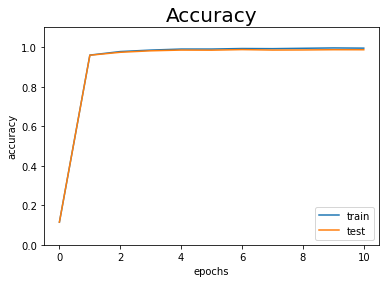

In [30]:
# x軸の値を生成
epochs = np.arange(len(train_acc_list))

# 作図
plt.plot(epochs, train_acc_list, label='train') # 訓練データ
plt.plot(epochs, test_acc_list, label='test') # テストデータ
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.ylim(0, 1.1) # y軸の範囲
plt.legend() # 凡例
plt.title("Accuracy", fontsize=20) # タイトル
plt.show()

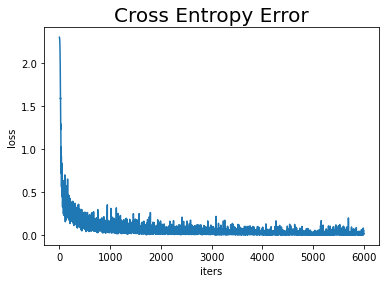

In [31]:
# x軸の値を生成
iters = np.arange(len(train_loss_list))

# 作図
plt.plot(iters, train_loss_list, label='train') # 訓練データ
plt.xlabel("iters") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.title("Cross Entropy Error", fontsize=20) # タイトル
plt.show()